### Import librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import probabilistic_hough_line
from skimage.draw import line
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

### Download and vizualise the data

In [3]:
easy_data=pd.read_parquet('Data Science Intern - LiDAR Technical Test/lidar_cable_points_hard.parquet')

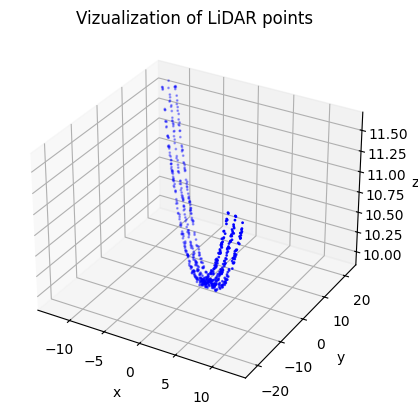

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(easy_data['x'], easy_data['y'], easy_data['z'], s=1, c='blue')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Vizualization of LiDAR points")
plt.show()


/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_26410/1138139346.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


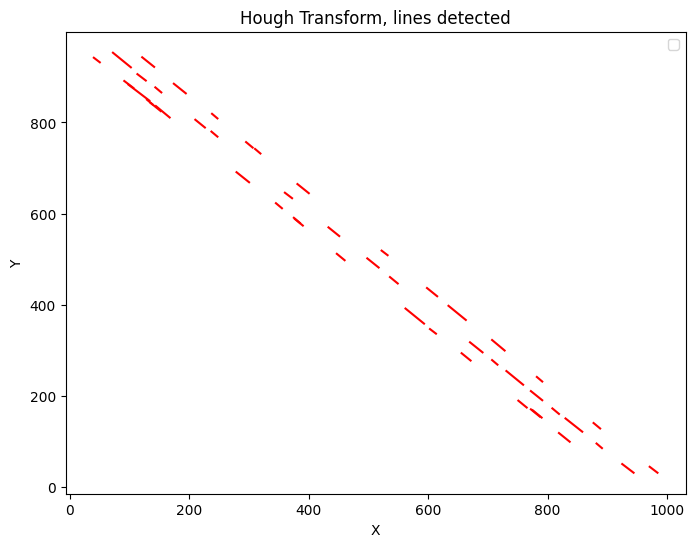

In [18]:
points_xy = easy_data[['x', 'y']].values


img_size = (1000, 1000)

# Take the extremes of the points to normalize the coordinates
x_min, x_max = points_xy[:, 0].min(), points_xy[:, 0].max()
y_min, y_max = points_xy[:, 1].min(), points_xy[:, 1].max()

# Normalization
x_normalized = np.clip((points_xy[:, 0] - x_min) / (x_max - x_min) * (img_size[1] - 1), 0, img_size[1] - 1)
y_normalized = np.clip((points_xy[:, 1] - y_min) / (y_max - y_min) * (img_size[0] - 1), 0, img_size[0] - 1)

# Create a binary image
edges = np.zeros(img_size, dtype=np.uint8)
edges[y_normalized.astype(int), x_normalized.astype(int)] = 1

# Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=10, line_gap=10)

plt.figure(figsize=(8, 6))
for line in lines:
    p0, p1 = line
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Hough Transform, lines detected')
plt.legend()
plt.show()



In [6]:
def calculate_slope_intercept(p0, p1):
    x0, y0 = p0
    x1, y1 = p1
    m = (y1 - y0) / (x1 - x0)
    b = y0 - m * x0
    return m, b

In [19]:


# Compute the slope and intercept for each line
slopes = []
intercepts = []
for p0, p1 in lines:
    m, b = calculate_slope_intercept(p0, p1)
    slopes.append(m)
    intercepts.append(b)

# stacking slopes and intercepts to create a feature matrix
slopes = np.array(slopes)
intercepts = np.array(intercepts)
features = np.vstack((slopes, intercepts)).T

# KMeans to cluster the lines
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features)
labels = kmeans.labels_

# Fo each cluster, take the average slope and intercept
equations = []
for label in set(labels):
    cluster_indices = np.where(labels == label)[0]
    
    cluster_slopes = slopes[cluster_indices]
    cluster_intercepts = intercepts[cluster_indices]
    
    avg_slope = np.mean(cluster_slopes)
    avg_intercept = np.mean(cluster_intercepts)
    equations.append((avg_slope, avg_intercept))
    
    print(f"Cluster {label + 1}: y = {avg_slope:.2f}x + {avg_intercept:.2f}")


Cluster 1: y = -1.05x + 988.89
Cluster 2: y = -1.09x + 1078.53
Cluster 3: y = -1.05x + 1028.13


Cluster 1: y = -1.82x + -1.70
Cluster 2: y = -1.88x + 1.51
Cluster 3: y = -1.82x + 0.05


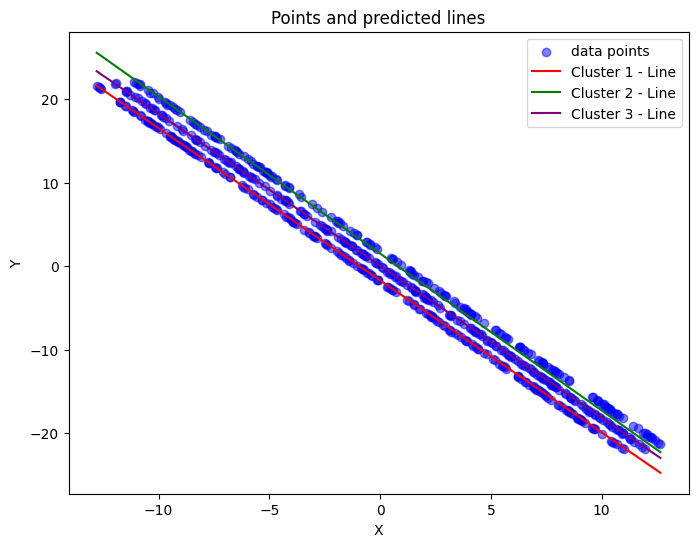

In [20]:
# Denormalization function
def denormalize_slope_intercept(slope_norm, intercept_norm, x_min, x_max, y_min, y_max):
    scale_x = x_max - x_min
    scale_y = y_max - y_min
    
    slope_denorm = slope_norm * scale_y / scale_x
    intercept_denorm = intercept_norm * scale_y/img_size[0] - slope_denorm * x_min +y_min
    
    return slope_denorm, intercept_denorm


# Denormalization of slopes and intercepts
denormalized_equations = []
for label in set(labels):
    avg_slope, avg_intercept = equations[label]
    denormalized_slope, denormalized_intercept = denormalize_slope_intercept(avg_slope, avg_intercept, x_min, x_max, y_min, y_max)
    
    denormalized_equations.append((denormalized_slope, denormalized_intercept))
    
    print(f"Cluster {label + 1}: y = {denormalized_slope:.2f}x + {denormalized_intercept:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(points_xy[:, 0], points_xy[:, 1], c='blue', alpha=0.5, label='data points')
x_values = np.linspace(easy_data['x'].min(), easy_data['x'].max(), 100)
colors = ['red', 'green', 'purple']

for label in set(labels):
    denormalized_slope, denormalized_intercept = denormalized_equations[label]
    y_values = denormalized_slope * x_values + denormalized_intercept
    plt.plot(x_values, y_values, color=colors[label], label=f'Cluster {label + 1} - Line')


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Points and predicted lines')
plt.legend()
plt.show()



In [23]:

points_xyz = easy_data[['x', 'y', 'z']].values
x_all, y_all, z_all = points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2]


cluster_points_list = [[] for _ in range(len(denormalized_equations))]

for i in range(len(points_xyz)):
    x, y = x_all[i], y_all[i]
    
    # compute the distance of each point to the predicted lines
    distances = []
    for m, b in denormalized_equations:
        d = np.abs(m * x - y + b) / np.sqrt(m ** 2 + 1)
        distances.append(d)
    
    # associate each point to the cluster with the minimum distance
    best_cluster = np.argmin(distances)
    cluster_points_list[best_cluster].append(points_xyz[i])

cluster_points_list = [np.array(points) for points in cluster_points_list]


In [25]:
from scipy.optimize import curve_fit
import numpy as np

def catenary(x, y0, c, x0):
    return y0 + c * (np.cosh((x - x0) / c) - 1)

def get_u_and_z(points_xyz, slope, intercept):
    # Line direction in (x, y)
    direction = np.array([1, slope])
    direction /= np.linalg.norm(direction)

    # Project each (x, y) point onto the direction vector
    xy = points_xyz[:, :2]
    projection_lengths = np.dot(xy, direction)
    
    # Recover z
    z = points_xyz[:, 2]
    
    return projection_lengths, z



In [ ]:
for i, cluster_points in enumerate(cluster_points_list):
    slope, intercept = denormalized_equations[i]
    
    u, z = get_u_and_z(cluster_points, slope, intercept)
    
    # Initial guess: y0 = min height, c = 10 (reasonable guess), x0 = mean of projection
    params, _ = curve_fit(catenary, u, z, p0=[z.min(), 10, u.mean()])
    
    z0, c, u0 = params
    print(f"Cluster {i + 1}: z = {z0:.2f} + {c:.2f} * (cosh((u - {u0:.2f}) / {c:.2f}) - 1)")


Cluster 1: z = 10.00 + 200.46 * (cosh((u - -0.46) / 200.46) - 1)
Cluster 2: z = 10.00 + 201.39 * (cosh((u - 0.45) / 201.39) - 1)
Cluster 3: z = 10.00 + 198.43 * (cosh((u - 0.03) / 198.43) - 1)


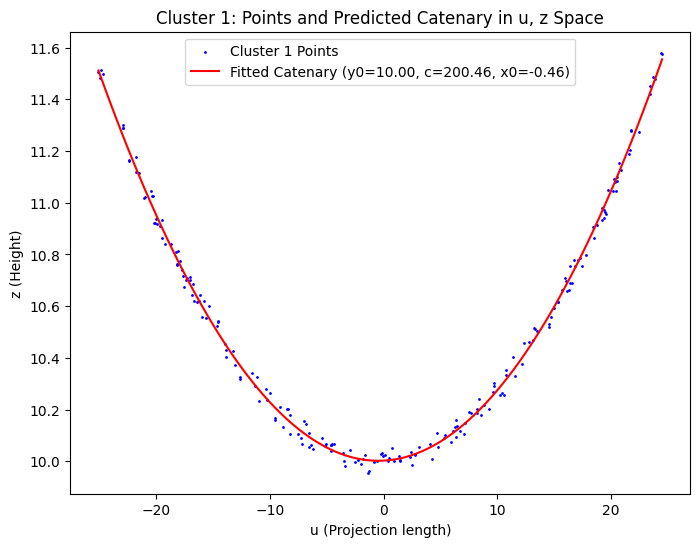

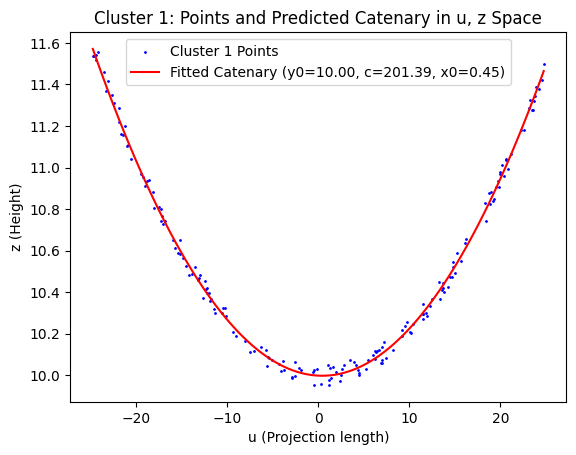

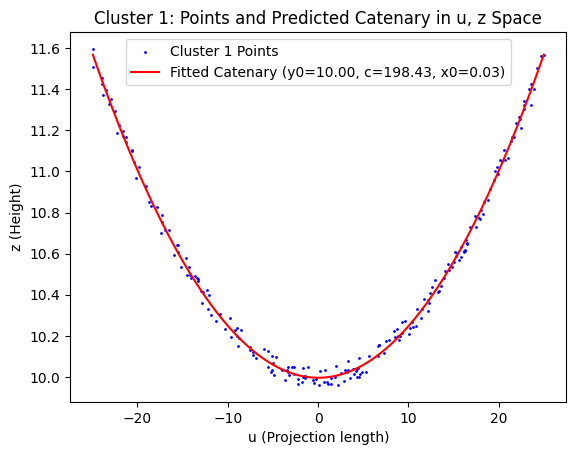

In [ ]:
# Create a figure for u, z space visualization
plt.figure(figsize=(8, 6))

for i in range(len(cluster_points_list)):
    cluster_points = cluster_points_list[i]  # Cluster 1

    if len(cluster_points) > 0:
        # Get the slope and intercept for cluster 1
        slope, intercept = denormalized_equations[i]
        
        # Get the u and z values for the points in cluster 1
        u, z = get_u_and_z(cluster_points, slope, intercept)
        
        # Plot the points in u, z space for cluster 1
        plt.scatter(u, z, label="Cluster 1 Points", c='blue', s=1)

        # Fit the catenary for cluster 1
        params, _ = curve_fit(catenary, u, z, p0=[z.min(), 10, u.mean()])
        
        # Get the parameters of the catenary
        z0, c, u0 = params
        
        # Generate the predicted catenary curve
        u_line = np.linspace(u.min(), u.max(), 100)
        z_line = catenary(u_line, z0, c, u0)
        
        # Plot the predicted catenary curve
        plt.plot(u_line, z_line, color='red', label=f"Fitted Catenary (z0={z0:.2f}, c={c:.2f}, u0={u0:.2f})")

    # Set the labels and title
    plt.xlabel("u (Projection length)")
    plt.ylabel("z (Height)")
    plt.title("Cluster 1: Points and Predicted Catenary in u, z Space")
    plt.legend()
    plt.show()


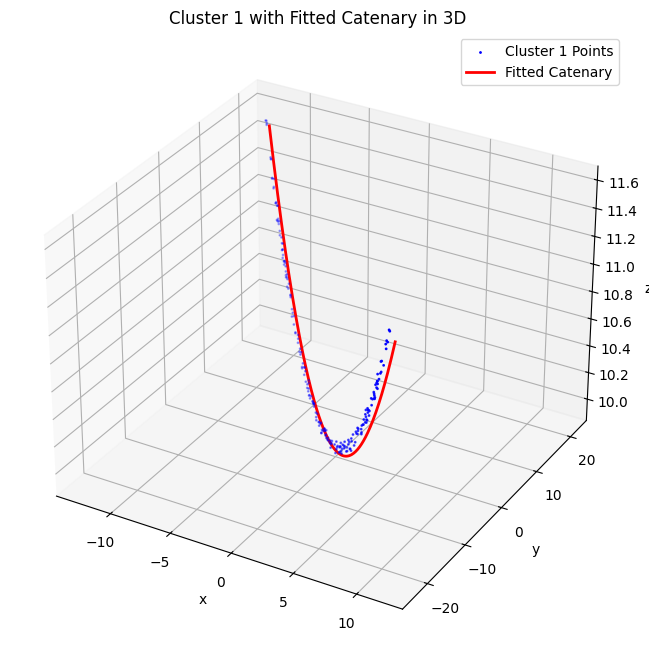

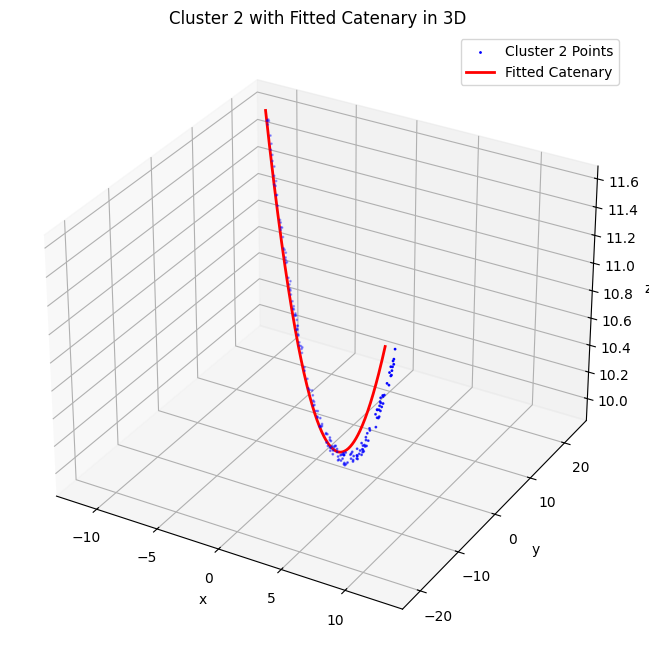

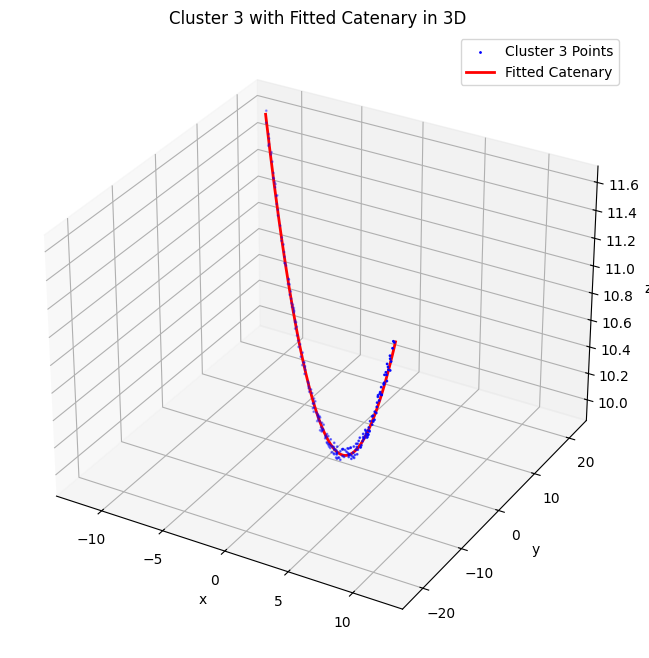

In [40]:
for i in range(len(cluster_points_list)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cluster_points = cluster_points_list[i]

    if len(cluster_points) > 0:
        # Récupère la droite associée
        slope, intercept = denormalized_equations[i]

        # Calcule (u, z)
        u, z = get_u_and_z(cluster_points, slope, intercept)

        # Fit la caténaire
        params, _ = curve_fit(catenary, u, z, p0=[z.min(), 10, u.mean()])
        z0, c, u0 = params

        # Points projetés à tracer (originaux)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=1, c='blue', label=f'Cluster {i+1} Points')

        # Recrée les points de la caténaire prédite en 3D
        u_line = np.linspace(u.min(), u.max(), 200)
        z_line = catenary(u_line, z0, c, u0)

        # Direction de la ligne dans (x, y)
        direction = np.array([1, slope])
        direction /= np.linalg.norm(direction)

        # Centre de la ligne (pour positionner les points 3D)
        origin = np.array([0, intercept])  # correspond au point (x=0, y=intercept)

        # Reconstitue les (x, y) à partir des u projetés
        xy_line = origin + np.outer(u_line, direction)  # chaque ligne est (x, y)

        # Sépare x et y
        x_line = xy_line[:, 0]
        y_line = xy_line[:, 1]

        # Trace la caténaire prédite en 3D
        ax.plot(x_line, y_line, z_line, color='red', linewidth=2, label='Fitted Catenary')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(f"Cluster {i+1} with Fitted Catenary in 3D")
    ax.legend()
    plt.show()
